In [19]:
import pynlo
import skopt
import skopt.plots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import njit
from scipy import constants
from scipy.fft import fft, ifft
from dataclasses import dataclass
from skopt import gp_minimize
from skopt.space import Real, Categorical
from skopt.utils import use_named_args

In [20]:
@dataclass
class GasPropertyData:
    name: str
    beta2: float          # [fs^2/(cm bar)]
    beta3: float          # [fs^3/(cm bar)]
    beta4: float          # [fs^4/(cm bar)]
    n2_at_one_bar: float  # [m^2/(W bar)]
    
    def __repr__(self):
        return (f"{self.name}: beta2={self.beta2} fs^2/(cm bar), "
                f"beta3={self.beta3} fs^3/(cm bar), "
                f"beta4={self.beta4} fs^4/(cm bar), "
                f"n2_at_one_bar={self.n2_at_one_bar} m^2/(W bar)")

noble_gases = [
    GasPropertyData(name="Neon", beta2=0.0202, beta3=0.0158, beta4=0, n2_at_one_bar=0.14e-23),
    GasPropertyData(name="Argon", beta2=0.1980, beta3=0.1586, beta4=0, n2_at_one_bar=1.74e-23),
    GasPropertyData(name="Krypton", beta2=0.3996, beta3=0.3298, beta4=0, n2_at_one_bar=4.03e-23),
    GasPropertyData(name="Xenon", beta2=0.9113, beta3=0.7836, beta4=0, n2_at_one_bar=11.15e-23),
]

In [21]:
def loadGasParameters(gas_name, gases):
    
    gas_dict = {gas.name.lower(): gas for gas in gases}
    gas = gas_dict.get(gas_name.lower(), "Gas property not found.")

    n2_at_one_bar = gas.n2_at_one_bar
    beta2 = gas.beta2 * (1e-3)**2 / 1e-5    # [ps^2/(km bar)]
    beta3 = gas.beta3 * (1e-3)**3 / 1e-5    # [ps^3/(km bar)]
    beta4 = gas.beta4 * (1e-3)**4 / 1e-5    # [ps^4/(km bar)]
    betas_at_one_bar = [beta2, beta3, beta4]
    
    return n2_at_one_bar, betas_at_one_bar

In [22]:
class GasPropertyBuilder:
    
    def __init__(self, fiber_length, fiber_radius, pulse_wavelength, n2_at_one_bar, betas_at_one_bar,  
                 constant_pressure=None, pressure_boundary=None, differential_pumping=False, pressure_in_Torr=False):
        
        assert (constant_pressure is not None) if not differential_pumping else True, \
        "A constant gas pressure is expected for non-differential pumping scheme."
        assert (pressure_boundary is not None) if differential_pumping else True, \
        "A list containing the boundary values of the gas pressure at both input \
        and output surface of the fiber is expected for differential pumping scheme."
        
        self.fiber_len = fiber_length
        self.fiber_rad = fiber_radius
        self.pulseWL = pulse_wavelength
        
        if differential_pumping:
            if len(pressure_boundary) != 2:
                print("A list containing the boundary values of the gas pressure at both input \
                and output surface of the fiber is expected for differential pumping scheme.")
            self.pressure_entr = pressure_boundary[0]
            self.pressure_exit = pressure_boundary[1]
        else:
            self.const_pressure = constant_pressure
        
        self.n2_at_one_bar = n2_at_one_bar
        self.betas_at_one_bar = betas_at_one_bar
        self.differential_pumping = differential_pumping
        self.pressure_in_Torr = pressure_in_Torr

    
    def torrToBar(self, pressure_Torr):
        """
        Unit conversion for gas pressure from torr to bar.
        
        1 torr is defined as exactly 1/760 of a standard atmosphere (1 atm = 101325 Pa), 
        1 pascal is equal to 1e-5 bar.

        Input(s):
        pressure_Torr: gas pressure [Torr]
        Output(s):
        pressure_Bar: gas pressure [Bar]
        """
        
        pressure_Pa = pressure_Torr * (101325/760)
        pressure_Bar = pressure_Pa * 1e-5
        
        return pressure_Bar
    
    def pressureDistribution(self, z=None):
        """
        Generate gas pressure distribution along the fiber under differential pumping.

        Reference: 
        Suda, Akira, et al.
        “Generation of Sub-10-Fs, 5-mJ-Optical Pulses Using a Hollow Fiber with a Pressure Gradient.”
        Applied Physics Letters, vol. 86, no. 11, 2005, https://doi.org/10.1063/1.1883706.
        
        Input(s):
        z: position grid along the fiber [m].
        fiber_len: length of the fiber [m].
        pressure_entr: gas pressure at the entrance [Torr].
        pressure_exit: gas pressure at the exit [Torr].
        Output(s):
        pressure_dist: gas pressure distribution along the fiber [Bar].
        """
        if self.differential_pumping:
            if self.pressure_in_Torr:
                pressure_entr = self.torrToBar(self.pressure_entr)
                pressure_exit = self.torrToBar(self.pressure_exit)
            else:
                pressure_entr = self.pressure_entr
                pressure_exit = self.pressure_exit
            
            pressure_dist = np.sqrt(pressure_entr**2 + (z/self.fiber_len) * (pressure_exit**2 - pressure_entr**2))
        else:
            if self.pressure_in_Torr:
                pressure_dist = self.torrToBar(self.const_pressure)
            else:
                pressure_dist = self.const_pressure

        return pressure_dist
    
    def dispersionFunction(self, z=None):
        """
        Generate the fiber dispersion that can vary as a function of the length z along the fiber 
        for differential pumping, return a tuple of beta coefficients as a function of z.
        
        Input(s):
        pressure_dist: gas pressure distribution along the fiber [Bar].
        betas_at_one_bar: a list of beta coefficients (i.e. [beta2, beta3, beta4]) specified at 1 bar [ps^n/km].
        Output(s):
        betas: a tuple of beta coefficients as a function of z [ps^n/m].
        """

        if self.differential_pumping:
            pressure_dist = self.pressureDistribution(z)
        else:
            pressure_dist = self.pressureDistribution()
            
        betas = [beta * (1/1e3) * pressure_dist for beta in self.betas_at_one_bar]
        
        return tuple(betas)
    
    def nonlinearIndexN2(self, z=None):
        """
        Calculate the nonlinear refractive index n2, return a constant for non-differential pumping, 
        or a distribution along the fiber for differential pumping.

        Input(s):
        pressure_dist: gas pressure distribution along the fiber under differential pumping [Bar].
        const_pressure: constant gas pressure for non-differential pumping [Bar].
        n2_at_one_bar: nonlinear refractive index of the gas reported at 1 bar [m^2/(W bar)].
        Output(s):
        n2: nonlinear refractive index at the specified pressure [m^2/W].
        """
        
        assert (z is None) if not self.differential_pumping else True, \
        "A position grid is not needed for non-differential pumping."
        assert (z is not None) if self.differential_pumping else True, \
        "A position grid is needed for differential pumping."
        
        if self.differential_pumping:
            pressure_dist = self.pressureDistribution(z)
        else:
            pressure_dist = self.pressureDistribution()
        
        n2 = pressure_dist * self.n2_at_one_bar
        
        return n2
    
    def gammaDistribution(self, z=None):
        """
        Calculate the nonlinear parameter Gamma using Gamma=(n2*w0)/(c*A_eff), return a constant 
        for non-differential pumping, or a distribution along the fiber for differential pumping. 
        Reference: Agrawal, Govind. Nonlinear Fiber Optics. Sixth edition., Academic Press, 2019.
        
        c: speed of light in vacuum [m/s].
        w0: angular frequency [rad/s].
        A_eff: effective core area of the fiber [m^2].

        Input(s):
        n2: nonlinear refractive index at the specified pressure [m^2/W].
        pulseWL: pulse central wavelength [nm].
        fiber_rad: radius of fiber [m].
        Output(s):
        Gamma: nonlinear parameter [1/(W m)]
        """
        
        assert (z is None) if not self.differential_pumping else True, \
        "A position grid is not needed for non-differential pumping."
        assert (z is not None) if self.differential_pumping else True, \
        "A position grid is needed for differential pumping."
        
        w0 = (2*np.pi*constants.c) / (self.pulseWL*1e-9)
        A_eff = np.pi * self.fiber_rad**2
        
        if self.differential_pumping:
            n2 = self.nonlinearIndexN2(z)
        else:
            n2 = self.nonlinearIndexN2()
            
        Gamma = (n2 * w0) / (constants.c * A_eff)
        
        return Gamma


In [23]:
def photonEnergyGrid(pulse):
    """
    Convert the grid corresponding to the complex electric field in frequency
    domain from angular frequency to photon energy in eV.
    
    Photon energy:
    E[J] = hbar * w = h * v
    E[eV] = E[J] / e
    
    Input(s):
    pulse: a pulse instance on which the conversion is performed.
    Output(s):
    W_eV: photon energy grid [eV].
    """
    
    W_eV = constants.h * pulse.F_mks / constants.e
    
    return W_eV

In [24]:
def dB(num):
    return 10 * np.log10(np.abs(num)**2)

In [25]:
def calc_FWHM(pulse):
    
    t = pulse.T_mks
    temporal_intensity = np.abs(pulse.AT)**2
    normalized_temporal_intensity = temporal_intensity / np.max(temporal_intensity)
    
    FWHM_filter = np.where(normalized_temporal_intensity >= 0.5)[0]
    
    if len(FWHM_filter) >= 2:
        FWHM_mks = t[FWHM_filter[-1]] - t[FWHM_filter[0]]
        return FWHM_mks
    else:
        print("Pulse does not have a well-defined FWHM.")
        return None

In [26]:
def super_gaussian(x, x0, w, P, A=1):
    """
    Generate a Super-Gaussian function.

    Input(s):
    x (numpy.ndarray): The array over which the Super-Gaussian function is evaluated.
    x0 (float): The center of the Super-Gaussian peak.
    w (float): The Full Width at Half Maximum (FWHM) of the peak.
    P (int): The order of the Super-Gaussian.
    A (float): The amplitude of the Super-Gaussian function. Default is 1.

    Output(s):
    super_gaussian (numpy.ndarray): The Super-Gaussian function evaluated at each point in x.
    """
    
    super_gaussian = A * np.exp(-np.log(2) * ((4 * (x - x0)**2) / w**2)**P)
    return super_gaussian

In [27]:
class PeakIntensityBuilder:
    
    def __init__(self, SHG_efficiency, pulse_duration, pulse_shape='sech', peak_intensity_CGS=None):
        
        self.eta = SHG_efficiency
        self.FWHM = pulse_duration                                # [s]
        self.peak_intensity_CGS = peak_intensity_CGS              # [W/cm^2]
        self.peak_intensity_MKS = self.toMKS(peak_intensity_CGS)  # [W/m^2]

        if pulse_shape == "sech":
            self.power_scaling_factor = np.arccosh(np.sqrt(2))
        elif pulse_shape == "gaussian":
            self.power_scaling_factor = 2 * np.sqrt(np.log(2)/np.pi)
            
    def toMKS(self, intensity_CGS):
        """
        Unit conversion for optical intensity from W/cm^2 to W/m^2.
        
        Input(s):
        intensity_CGS: intensity [W/cm^2]
        Output(s):
        intensity_MKS: intensity [W/m^2]
        """
        intensity_MKS = intensity_CGS / (1e-2)**2
        return intensity_MKS
    
    def toCGS(self, intensity_MKS):
        """
        Unit conversion for optical intensity from W/m^2 to W/cm^2.
        
        Input(s):
        intensity_MKS: intensity [W/m^2]
        Output(s):
        intensity_CGS: intensity [W/cm^2]
        """
        intensity_CGS = intensity_MKS / (1e2)**2
        return intensity_CGS
    
    def divideEPP(self, input_EPP):
        
        EPP_FD = (1 - self.eta) * input_EPP
        EPP_SH = self.eta * input_EPP
        return EPP_FD, EPP_SH
    
    def calcFiberRadius(self, input_EPP):
        """
        Calculate the maximum fiber radius in [m] that maintains the required peak intensity
        for a given pulse energy and pulse duration.
        """
        assert self.peak_intensity_MKS is not None, \
        "A target peak intensity must be provided to enable this function."
        
        EPP_FD, EPP_SH = self.divideEPP(input_EPP)
        fiber_rad = np.sqrt((self.power_scaling_factor * EPP_SH) / (self.peak_intensity_MKS * self.FWHM * np.pi))
        return fiber_rad
    
    def calcPeakIntensity(self, reference_EPP, fiber_radius):
        """
        Calculate the resulting peak intensity in [W/cm^2] from the given pulse energy,
        pulse duration and fiber radius.
        """
        peak_intensity_MKS = (self.power_scaling_factor * reference_EPP) / (self.FWHM * np.pi * fiber_radius**2)
        peak_intensity_CGS = self.toCGS(peak_intensity_MKS)
        return peak_intensity_CGS
    
    def calcEPP(self, fiber_radius):
        """
        Calculate the pulse energies in [J] that maintain the required peak intensity
        for a given fiber radius and pulse duration.
        """
        assert self.peak_intensity_MKS is not None, \
        "A target peak intensity must be provided to enable this function."
        
        EPP_SH = self.peak_intensity_MKS * self.FWHM * np.pi * fiber_radius**2 / self.power_scaling_factor
        input_EPP = EPP_SH / self.eta
        EPP_FD = (1 - self.eta) * input_EPP
        return input_EPP, EPP_FD, EPP_SH
        

In [28]:
class NonlinearConversionEfficiency():

    def __init__(self, input_EPP, input_FWHM, input_pulse_shape, output_EPP, output_peak_power):
        self.input_EPP = input_EPP
        self.input_FWHM = input_FWHM
        self.output_EPP = output_EPP
        self.output_peak_power = output_peak_power
        
        if input_pulse_shape == "sech":
            self.power_scaling_factor = np.arccosh(np.sqrt(2))
        elif input_pulse_shape == "gaussian":
            self.power_scaling_factor = 2 * np.sqrt(np.log(2)/np.pi)
        
    def energy_conversion_efficiency(self):
        energy_eta = self.output_EPP / self.input_EPP
        return energy_eta
        
    def peak_power_conversion_efficiency(self):
        input_peak_power = self.power_scaling_factor * self.input_EPP / self.input_FWHM
        peak_power_eta = self.output_peak_power / input_peak_power
        return peak_power_eta

In [29]:
class PulsePropertyAccessor:
    
    def __init__(self, pulse, pulse_shape="sech"):
        
        self.pulse = pulse
        
        if pulse_shape == "sech":
            self.autocorrelation_scaling_factor = 0.6482
            self.power_scaling_factor = np.arccosh(np.sqrt(2))
        elif pulse_shape == "gaussian":
            self.autocorrelation_scaling_factor = 0.7071
            self.power_scaling_factor = 2 * np.sqrt(np.log(2)/np.pi)
    
    def calc_epp(self):
        
        pulse_energy = self.pulse.calc_epp()
        return pulse_energy
        
    def calc_pulse_length(self):
        
        intensity_autocorrelation = fft_autocorrelation(np.abs(self.pulse.AT)**2)
        pulse_FWHM = calc_pulse_length_numba(self.pulse.T_mks, intensity_autocorrelation, self.autocorrelation_scaling_factor)
        return pulse_FWHM
        
    def calc_peak_power(self):
        
        pulse_energy = self.calc_epp()
        pulse_FWHM = self.calc_pulse_length()
        peak_power = calc_peak_power_numba(pulse_energy, pulse_FWHM, self.power_scaling_factor)
        return peak_power

    def get_autocorrelation(self):
        """
        Returns the autocorrelation of the pulse in the time domain and the corresponding time axis.
        
        Returns
        -------
        T_ac : numpy.ndarray
            The time axis for the autocorrelation.
        intensity_autocorrelation : numpy.ndarray
            The intensity autocorrelation of the pulse.
        """
        intensity_autocorrelation = fft_autocorrelation(np.abs(self.pulse.AT)**2)
        dt = np.mean(np.diff(self.pulse.T_mks))
        T_ac = np.linspace(-len(intensity_autocorrelation)//2, len(intensity_autocorrelation)//2 - 1, len(intensity_autocorrelation)) * dt
        return T_ac, intensity_autocorrelation

def fft_autocorrelation(signal):
    
    n = len(signal)
    f_signal = fft(signal)
    f_signal_conj = np.conj(f_signal)
    result = ifft(f_signal * f_signal_conj).real
    return np.fft.fftshift(result) / n

@njit
def calc_pulse_length_numba(T_mks, intensity_autocorrelation, autocorrelation_scaling_factor):
    
    half_maximum = np.max(intensity_autocorrelation) / 2
    indices_above_half_maximum = np.where(intensity_autocorrelation >= half_maximum)[0]
    FWHM_autocorrelation = T_mks[indices_above_half_maximum[-1]] - T_mks[indices_above_half_maximum[0]]
    FWHM_pulse = FWHM_autocorrelation * autocorrelation_scaling_factor
    return FWHM_pulse

@njit
def calc_peak_power_numba(pulse_energy, pulse_FWHM, power_scaling_factor):
    
    peak_power = pulse_energy * power_scaling_factor / pulse_FWHM
    return peak_power

In [30]:
class PlotConstructor:
    
    def __init__(self, AW, AT, pulse_FD, pulse_SH, pulse, pulse_out, fiber_len):
        self.AW = AW
        self.AT = AT
        self.pulse_FD = pulse_FD
        self.pulse_SH = pulse_SH
        self.pulse = pulse
        self.pulse_out = pulse_out
        self.fiber_len = fiber_len
        self.W_eV = photonEnergyGrid(pulse)
        self.zW = dB(np.transpose(AW)[:, (self.W_eV > 0)])
        self.zT = dB(np.transpose(AT))
        self.saved_plots = {}

    def spectral_power_density(self, save=False, use_dB=False):
        plt.figure()
        if use_dB:
            spectral_power = dB(self.pulse_out.AW[self.W_eV > 0])
            ylabel = 'Spectral power density [dB]'
            plt.plot(self.W_eV[self.W_eV > 0], spectral_power, color='r', label='output pulse')
            plt.ylim(-200, None)
        else:
            spectral_power = np.abs(self.pulse_out.AW[self.W_eV > 0])**2
            ylabel = 'Spectral power density [W/eV]'
            plt.plot(self.W_eV[self.W_eV > 0], spectral_power, color='r', label='output pulse')
            plt.yscale('log')
            plt.ylim(1e-15, None)

        plt.xlabel('Photon energy [eV]')
        plt.ylabel(ylabel)
        plt.xlim(0, 20)
        
        if save:
            plt.savefig('plot1.png')
        self.saved_plots['spectral_power_density'] = plt.gcf()
        plt.show()
        plt.close()

    def temporal_power_density(self, save=False, use_dB=False):
        plt.figure()
        if use_dB:
            temporal_power = dB(self.pulse_out.AT)
            ylabel = 'Temporal power density [dB]'
            plt.plot(self.pulse_SH.T_ps, temporal_power, color='r', label='output pulse')
            # No y-limit set for this plot
        else:
            temporal_power = np.abs(self.pulse_out.AT)**2
            ylabel = 'Temporal power density [W/eV]'
            plt.plot(self.pulse_SH.T_ps, temporal_power, color='r', label='output pulse')
            plt.yscale('log')

        x_ticks = np.arange(np.min(self.pulse_SH.T_ps), np.max(self.pulse_SH.T_ps) + 1, 1)
        plt.xticks(x_ticks)
        plt.xlim(np.min(self.pulse_SH.T_ps), np.max(self.pulse_SH.T_ps))
        plt.xlabel('Time [ps]')
        plt.ylabel(ylabel)
        
        if save:
            plt.savefig('plot2.png')
        self.saved_plots['temporal_power_density'] = plt.gcf()
        plt.show()
        plt.close()

    def spectral_broadening_along_fiber(self, save=True):
        plt.figure()
        extent = (np.min(self.W_eV[self.W_eV > 0]), np.max(self.W_eV[self.W_eV > 0]), 0, self.fiber_len)
        plt.imshow(self.zW, extent=extent, vmin=np.max(self.zW) - 250.0, vmax=np.max(self.zW), aspect='auto', origin='lower', cmap='jet')
        plt.xlim(0, 20)
        plt.xlabel('Photon energy [eV]')
        plt.ylabel('Propagation distance [mm]')
        
        if save:
            plt.savefig('plot3.png')
        self.saved_plots['spectral_broadening_along_fiber'] = plt.gcf()
        plt.show()
        plt.close()

    def temporal_broadening_along_fiber(self, save=True):
        plt.figure()
        extent = (np.min(self.pulse_SH.T_ps), np.max(self.pulse_SH.T_ps), 0, self.fiber_len)
        plt.imshow(self.zT, extent=extent, vmin=np.max(self.zT) - 60.0, vmax=np.max(self.zT), aspect='auto', origin='lower', cmap='jet')
        x_ticks = np.arange(np.min(self.pulse_SH.T_ps), np.max(self.pulse_SH.T_ps) + 1, 1)
        plt.xticks(x_ticks)
        plt.xlabel('Time [ps]')
        plt.ylabel('Propagation distance [mm]')
        
        if save:
            plt.savefig('plot4.png')
        self.saved_plots['temporal_broadening_along_fiber'] = plt.gcf()
        plt.show()
        plt.close()

    def combined_plot(self, save=False, use_dB=False):
        fig = plt.figure(figsize=(15, 10))
        ax0 = plt.subplot2grid((2, 2), (0, 0), rowspan=1)
        ax1 = plt.subplot2grid((2, 2), (0, 1), rowspan=1)
        ax2 = plt.subplot2grid((2, 2), (1, 0), rowspan=1, sharex=ax0)
        ax3 = plt.subplot2grid((2, 2), (1, 1), rowspan=1, sharex=ax1)

        if use_dB:
            spectral_power = dB(self.pulse_out.AW[self.W_eV > 0])
            temporal_power = dB(self.pulse_out.AT)
            ylabel_spectral = 'Spectral power density [dB]'
            ylabel_temporal = 'Temporal power density [dB]'
            ax0.plot(self.W_eV[self.W_eV > 0], spectral_power, color='r', label='output pulse')
            ax1.plot(self.pulse_SH.T_ps, temporal_power, color='r', label='output pulse')
            ax0.set_ylim(-200, None)  # Set lower y-axis limit to -200 dB, no upper limit
            # No y-limit set for the upper right plot (ax1)
        else:
            spectral_power = np.abs(self.pulse_out.AW[self.W_eV > 0])**2
            temporal_power = np.abs(self.pulse_out.AT)**2
            ylabel_spectral = 'Spectral power density [W/eV]'
            ylabel_temporal = 'Temporal power density [W/eV]'
            ax0.plot(self.W_eV[self.W_eV > 0], spectral_power, color='r', label='output pulse')
            ax1.plot(self.pulse_SH.T_ps, temporal_power, color='r', label='output pulse')
            ax0.set_yscale('log')
            ax1.set_yscale('log')
            ax0.set_ylim(1e-15, None)

        extent_W = (np.min(self.W_eV[self.W_eV > 0]), np.max(self.W_eV[self.W_eV > 0]), 0, self.fiber_len)
        ax2.imshow(self.zW, extent=extent_W, vmin=np.max(self.zW) - 250.0, vmax=np.max(self.zW), aspect='auto', origin='lower', cmap='jet')

        extent_T = (np.min(self.pulse_SH.T_ps), np.max(self.pulse_SH.T_ps), 0, self.fiber_len)
        ax3.imshow(self.zT, extent=extent_T, vmin=np.max(self.zT) - 60.0, vmax=np.max(self.zT), aspect='auto', origin='lower', cmap='jet')

        ax0.set_xlim(0, 20)

        x_ticks = np.arange(np.min(self.pulse_SH.T_ps), np.max(self.pulse_SH.T_ps) + 1, 1)
        ax1.set_xticks(x_ticks)

        ax0.set_ylabel(ylabel_spectral)
        ax1.set_ylabel(ylabel_temporal)
        ax2.set_ylabel('Propagation distance [mm]')
        ax3.set_ylabel('Propagation distance [mm]')

        ax2.set_xlabel('Photon energy [eV]')
        ax3.set_xlabel('Time [ps]')

        plt.tight_layout()
        
        if save:
            plt.savefig('combined_plot.png')
        self.saved_plots['combined_plot'] = plt.gcf()
        plt.show()
        plt.close()

    def display_saved_plots(self):
        for plot_name, fig in self.saved_plots.items():
            print(f"Displaying {plot_name}")
            plt.show()

In [31]:
# pulse parameters
FWHM = 0.22                # pulse duration [ps]
pulseWL = 1024             # pulse central wavelength [nm]
frep_MHz = 0.06            # pulse repetition rate [MHz]
max_EPP = 100e-6           # maximum pulse energy [J]
GDD = 0.0                  # group delay dispersion [ps^2]
TOD = 0.0                  # third order dispersion [ps^3]
SHG_efficiency = 0.2       # SHG conversion efficiency
peak_intensity_CGS = 2e12  # peak intensity for nonlinear processes [W/cm^2]

# fiber parameters
fiber_rad = 35e-6                          # fiber radius [m]
fibWL = pulseWL                            # center wavelength of fiber [nm]
Alpha = 0.0                                # attentuation coefficient [dB/cm]
alpha = np.log((10**(Alpha * 0.1))) * 100  # convert from dB/cm to 1/m

# simulation parameters
Window = 5        # simulation window [ps]
Points = 2**16    # simulation points
Raman = True      # Enable Raman effect?
Steep = True      # Enable self steepening?

n2_at_one_bar, betas_at_one_bar = loadGasParameters("Xenon", noble_gases)


In [32]:
def run_simulation(gas_pressure, fiber_length):

    pressure = gas_pressure
    Length = fiber_length
    Steps = fiber_length
    
    intensitybuilder = PeakIntensityBuilder(SHG_efficiency=SHG_efficiency, 
                                            pulse_duration=FWHM*1e-12, 
                                            pulse_shape="gaussian",
                                            peak_intensity_CGS=peak_intensity_CGS)
    
    total_EPP, EPP_FD, EPP_SH = intensitybuilder.calcEPP(fiber_radius=fiber_rad)

    # use static field
    gasbuilder = GasPropertyBuilder(fiber_length=Length*1e-3, fiber_radius=fiber_rad, pulse_wavelength=pulseWL, 
                                    betas_at_one_bar=betas_at_one_bar, constant_pressure=pressure, pressure_boundary=None, 
                                    n2_at_one_bar=n2_at_one_bar, differential_pumping=False, pressure_in_Torr=False)

    # create the fiber
    fiber = pynlo.media.fibers.fiber.FiberInstance()
    fiber.generate_fiber(Length*1e-3, center_wl_nm=fibWL, betas=gasbuilder.dispersionFunction(z=None), 
                         gamma_W_m=gasbuilder.gammaDistribution(z=None), gvd_units='ps^n/m', gain=-alpha)

    # create the fundamental pulse
    pulse_FD = pynlo.light.DerivedPulses.GaussianPulse(
        EPP_FD*frep_MHz*1e6, FWHM, pulseWL, time_window_ps=Window,
        GDD=GDD, TOD=TOD, NPTS=Points, frep_MHz=frep_MHz, power_is_avg=True
    )
    pulse_FD.set_epp(EPP_FD)
    
    # create the second harmonic pulse
    pulse_SH = pynlo.light.DerivedPulses.GaussianPulse(
        EPP_SH*frep_MHz*1e6, FWHM, pulseWL/2, time_window_ps=Window,
        GDD=GDD, TOD=TOD, NPTS=Points, frep_MHz=frep_MHz, power_is_avg=True
    )
    pulse_SH = pulse_SH.interpolate_to_new_center_wl(pulseWL)
    pulse_SH.set_epp(EPP_SH)

    # create the combined pulse
    pulse = pynlo.light.PulseBase.Pulse()
    pulse.set_NPTS(Points)
    pulse.set_time_window_ps(Window)
    pulse.set_frep_MHz(frep_MHz)
    pulse.set_center_wavelength_nm(pulseWL)
    pulse.set_AW(pulse_FD.AW + pulse_SH.AW)

    # propagation
    evol = pynlo.interactions.FourWaveMixing.SSFM.SSFM(local_error=0.001, USE_SIMPLE_RAMAN=True, 
                                                       disable_Raman=np.logical_not(Raman), 
                                                       disable_self_steepening=np.logical_not(Steep))
    
    y, AW, AT, pulse_out = evol.propagate(pulse_in=pulse, fiber=fiber, n_steps=Steps, reload_fiber_each_step=False)

    TH_mask_center = pulseWL/3    # center frequency of the mask [nm]
    TH_mask_width = 50            # width of the mask [nm]
    TH_mask_order = 8             # order of the super Gaussian (2 is a Gaussian, higher values create a flatter top)
    
    FH_mask_center = pulseWL/4    # center wavelength of the mask [nm]
    FH_mask_width = 50            # width of the mask [nm]
    FH_mask_order = 8             # order of the super Gaussian (2 is a Gaussian, higher values create a flatter top)
    
    # create super-Gaussian masks
    TH_mask = super_gaussian(pulse.wl_nm, TH_mask_center, TH_mask_width, TH_mask_order)
    FH_mask = super_gaussian(pulse.wl_nm, FH_mask_center, FH_mask_width, FH_mask_order)
    
    # create the third harmonic pulse
    pulse_TH = pynlo.light.PulseBase.Pulse()
    pulse_TH.set_NPTS(Points)
    pulse_TH.set_time_window_ps(Window)
    pulse_TH.set_frep_MHz(frep_MHz)
    pulse_TH.set_center_wavelength_nm(pulseWL/3)
    pulse_TH.set_AW(pulse_out.AW * TH_mask)
    
    pulse_TH_property_accessor = PulsePropertyAccessor(pulse=pulse_TH, pulse_shape="gaussian")
    pulse_TH_energy = pulse_TH_property_accessor.calc_epp()
    pulse_TH_FWHM = pulse_TH_property_accessor.calc_pulse_length()
    pulse_TH_peak_power = pulse_TH_property_accessor.calc_peak_power()
    
    
    # create the fourth harmonic pulse
    pulse_FH = pynlo.light.PulseBase.Pulse()
    pulse_FH.set_NPTS(Points)
    pulse_FH.set_time_window_ps(Window)
    pulse_FH.set_frep_MHz(frep_MHz)
    pulse_FH.set_center_wavelength_nm(pulseWL/4)
    pulse_FH.set_AW(pulse_out.AW * FH_mask)
        
    pulse_FH_property_accessor = PulsePropertyAccessor(pulse=pulse_FH, pulse_shape="gaussian")
    pulse_FH_energy = pulse_FH_property_accessor.calc_epp()
    pulse_FH_FWHM = pulse_FH_property_accessor.calc_pulse_length()
    pulse_FH_peak_power = pulse_FH_property_accessor.calc_peak_power()
    
    
    pulse_TH_conversion = NonlinearConversionEfficiency(input_EPP=total_EPP, input_FWHM=FWHM*1e-12, input_pulse_shape='gaussian', output_EPP=pulse_TH_energy, output_peak_power=pulse_TH_peak_power)
    pulse_FH_conversion = NonlinearConversionEfficiency(input_EPP=total_EPP, input_FWHM=FWHM*1e-12, input_pulse_shape='gaussian', output_EPP=pulse_FH_energy, output_peak_power=pulse_FH_peak_power)
    
    pulse_TH_energy_eta = pulse_TH_conversion.energy_conversion_efficiency()
    pulse_FH_energy_eta = pulse_FH_conversion.energy_conversion_efficiency()
    pulse_TH_peak_power_eta = pulse_TH_conversion.peak_power_conversion_efficiency()
    pulse_FH_peak_power_eta = pulse_FH_conversion.peak_power_conversion_efficiency()
    
    return pulse_TH_energy, pulse_FH_energy, pulse_TH_peak_power, pulse_FH_peak_power, pulse_TH_energy_eta, pulse_FH_energy_eta, pulse_TH_peak_power_eta, pulse_FH_peak_power_eta

In [33]:
# parameter space for Bayesian optimisation
param_space = [
    Real(1e-3, 1, name='gas pressure'),
    Real(1, 100, name='fiber length')
]

# weights for the objectives
weight_pulse_TH_energy = 1
weight_pulse_TH_energy_eta = 0
weight_pulse_FH_energy_eta = 0
weight_pulse_TH_peak_power_eta = 0
weight_pulse_FH_peak_power_eta = 0

# initialise global variable to store the best results
best_result = {
    "params": None,
    "pulse_TH_energy": None,
    "pulse_FH_energy": None,
    "pulse_TH_peak_power": None,
    "pulse_FH_peak_power": None,
    "pulse_TH_energy_eta": None,
    "pulse_FH_energy_eta": None,
    "pulse_TH_peak_power_eta": None,
    "pulse_FH_peak_power_eta": None
}

# objective function
@use_named_args(param_space)
def objective(**params):
    global best_result
    
    gas_pressure = params['gas pressure']
    fiber_length = params['fiber length']
    
    pulse_TH_energy, pulse_FH_energy, pulse_TH_peak_power, pulse_FH_peak_power, pulse_TH_energy_eta, pulse_FH_energy_eta, pulse_TH_peak_power_eta, pulse_FH_peak_power_eta = run_simulation(gas_pressure, fiber_length)
    
    # combine the objectives
    objective_value = (weight_pulse_TH_energy * (-pulse_TH_energy) +
                       weight_pulse_TH_energy_eta * (-pulse_TH_energy_eta) + 
                       weight_pulse_FH_energy_eta * (-pulse_FH_energy_eta) + 
                       weight_pulse_TH_peak_power_eta * (-pulse_TH_peak_power_eta) + 
                       weight_pulse_FH_peak_power_eta * (-pulse_FH_peak_power_eta))
    
    # check if this is the best result so far
    if best_result["params"] is None or objective_value < best_result["objective_value"]:
        best_result["params"] = params
        best_result["pulse_TH_energy"] = pulse_TH_energy
        best_result["pulse_FH_energy"] = pulse_FH_energy
        best_result["pulse_TH_peak_power"] = pulse_TH_peak_power
        best_result["pulse_FH_peak_power"] = pulse_FH_peak_power
        best_result["pulse_TH_energy_eta"] = pulse_TH_energy_eta
        best_result["pulse_FH_energy_eta"] = pulse_FH_energy_eta
        best_result["pulse_TH_peak_power_eta"] = pulse_TH_peak_power_eta
        best_result["pulse_FH_peak_power_eta"] = pulse_FH_peak_power_eta
        best_result["objective_value"] = objective_value
    
    return objective_value

In [34]:
# perform Bayesian optimisation
res = gp_minimize(objective, param_space, acq_func="PI", xi=0.1, n_calls=100, n_random_starts=100, noise=0.1**2, random_state=42, n_restarts_optimizer=5)

# return the parameters at the optimum and the corresponding energy and peak power values
optimal_params = best_result["params"]
optimal_TH_energy = best_result["pulse_TH_energy"]
optimal_FH_energy = best_result["pulse_FH_energy"]
optimal_TH_energy_eta = best_result["pulse_TH_energy_eta"]
optimal_FH_energy_eta = best_result["pulse_FH_energy_eta"]
optimal_TH_peak_power = best_result["pulse_TH_peak_power"]
optimal_FH_peak_power = best_result["pulse_FH_peak_power"]
optimal_TH_peak_power_eta = best_result["pulse_TH_peak_power_eta"]
optimal_FH_peak_power_eta = best_result["pulse_FH_peak_power_eta"]

optimal_params, optimal_TH_energy, optimal_FH_energy, optimal_TH_energy_eta, optimal_FH_energy_eta, optimal_TH_peak_power, optimal_FH_peak_power, optimal_TH_peak_power_eta, optimal_FH_peak_power_eta


({'gas pressure': 0.16912275113075767, 'fiber length': 22.65765773773396},
 2.8109961880730397e-07,
 1.232414803517436e-09,
 0.0031190289393105844,
 1.367464478861745e-05,
 2053292.8010015632,
 11613.197671043225,
 0.0053353746758269755,
 3.0176290848160264e-05)

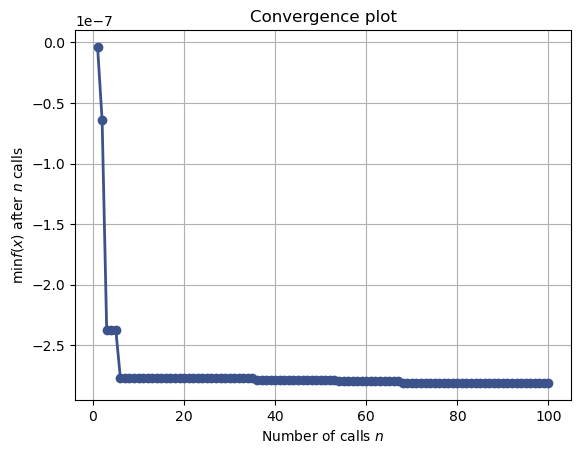

In [35]:
_ = skopt.plots.plot_convergence(res)
plt.show()

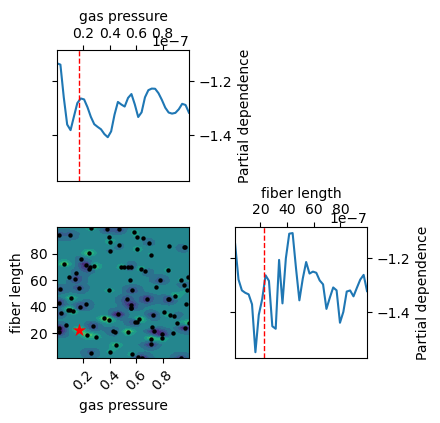

In [36]:
_ = skopt.plots.plot_objective(res)
plt.show()

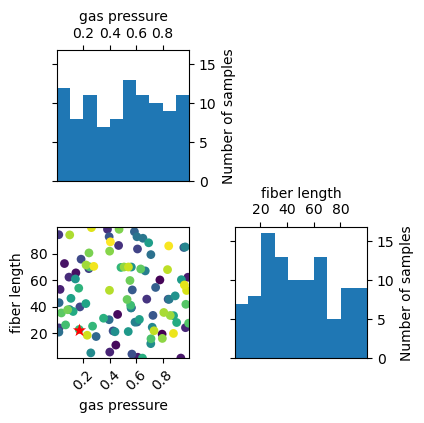

In [37]:
_ = skopt.plots.plot_evaluations(res, bins=10)
plt.show()

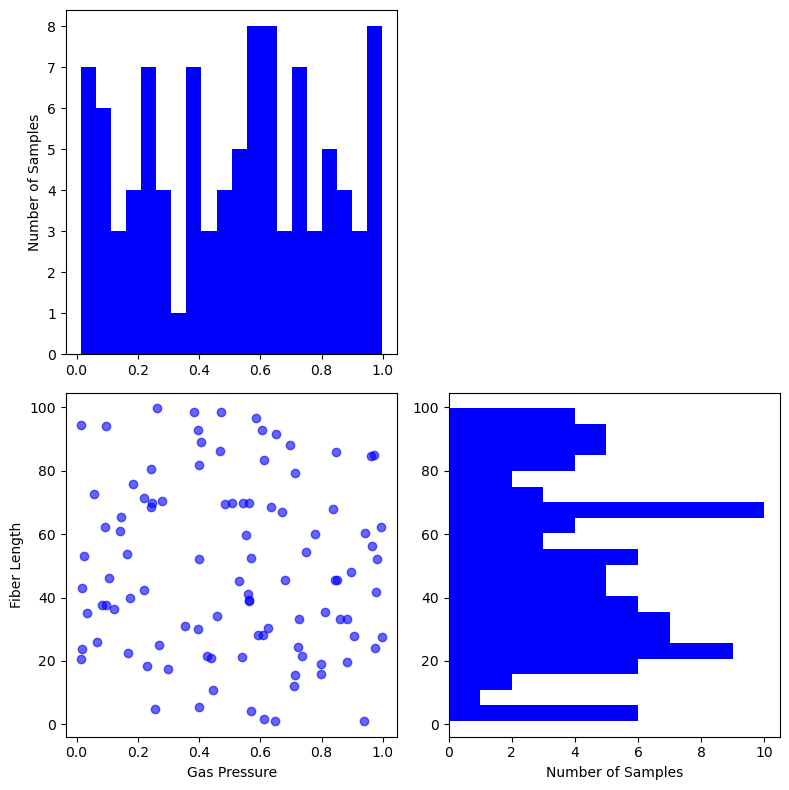

In [40]:
# Assuming `x_iters` contains the sampled points
x_iters = np.array(res['x_iters'])

fig, ax = plt.subplots(2, 2, figsize=(8, 8), gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1, 1]})

# Scatter plot for the parameter space
ax[1, 0].scatter(x_iters[:, 0], x_iters[:, 1], c='blue', marker='o', alpha=0.6)

# Histograms
ax[0, 0].hist(x_iters[:, 0], bins=20, color='blue')
ax[1, 1].hist(x_iters[:, 1], bins=20, color='blue', orientation='horizontal')

# Remove unused subplot
ax[0, 1].axis('off')

# Set labels
ax[1, 0].set_xlabel('Gas Pressure')
ax[1, 0].set_ylabel('Fiber Length')
ax[0, 0].set_ylabel('Number of Samples')
ax[1, 1].set_xlabel('Number of Samples')

plt.tight_layout()
plt.show()